## Inference pipeline

In [5]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import contextlib
import matplotlib.patches as patches
import os
import imageio
import sys
from glob import glob
import os
import cv2
import numpy as np
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from skimage.transform import resize
import os
from numpy import random
import time
from PIL import Image
import contextlib
from tqdm import tqdm
import cv2
from pathlib import Path
import random
import math

### Download the Yolov5 code and model from the repository

This notebook is based on git tag v6.0-39-g5d4258f from the repo https://github.com/ultralytics/yolov5

> !git rev-parse HEAD
- 5d4258fac5e6ceaa9c897f841cb737c56717a996

In [2]:
%pwd

'/app'

In [3]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd /app/yolov5
#!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

fatal: destination path 'yolov5' already exists and is not an empty directory.
/app/yolov5


In [7]:
%cd /app/yolov5
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch
%pwd

/app/yolov5


'/app/yolov5'

In [8]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.0a0+52ea372 CPU


/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:104.)
  return torch._C._cuda_getDeviceCount() > 0


In [9]:
import matplotlib.patches as patches
def get_bounding_box(img):
    minx = []
    miny = []
    maxx = []
    maxy = []
    contours = find_contours(img.astype(float), 0.5)
    for contour in contours:
        minx.append(np.min(contour[:,1]))
        maxx.append(np.max(contour[:,1]))
        miny.append(np.min(contour[:,0]))
        maxy.append(np.max(contour[:,0]))
        
    if len(minx) > 0:
        return [(a, b, w-a, h-b) for a, b, w, h in zip(minx, miny, maxx, maxy)]
    else:
        return None
    
def plot_bounding_box(img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    
    boxes = get_bounding_box(img)
    if boxes:
        for box in boxes:
            x,y,w,h = box
            print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
            rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

In [10]:
import os, shutil
import glob
from tqdm import tqdm

def removedir(dirname):
    print("Directory {} exists, removing!".format(dirname))
    files = glob.glob(dirname + "/*")
    for i in tqdm(range(len(files))):
        if os.path.isdir(files[i]):
            shutil.rmtree(files[i])
            

def save_patient_image_and_bbox(patient_id, root_dir='/app/yolov5/test'):
    
    # create the directories
    imagedirname = None
    labeldirname = None
    dirname = patient_id#.replace('-','_')
    patientdir = root_dir + "/" + dirname
    imagedirname = patientdir + "/" + 'images'
    labeldirname = patientdir + "/" + 'labels'
     
    #clean up any previous data for this patient
    if os.path.exists(patientdir):
        removedir(patientdir)

    print("Creating directory {}".format(imagedirname))
    os.makedirs(imagedirname)

    print("Creating directory {}".format(labeldirname))
    os.makedirs(labeldirname)
            
    # query the image data from the CT volume
    print("Reading data for patient {}".format(patient_id))
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    with contextlib.redirect_stdout(None):
        vol = scan.to_volume()

    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Number of nodules for patient {} is {}".format(patient_id, nodule_num))
    
    # save the image, even if it does not have any nodules, this will be used for predictions
    if nodule_num <= 0: # no nodules
        num_slices = vol.shape[2]
        im = vol[:,:,int(num_slices/2)]
        image_filename = "{}_{}.jpg".format(patient_id, int(num_slices/2))
        print("Saving image to file {}".format(imagedirname + "/" + image_filename))
        imageio.imwrite(imagedirname + "/" + image_filename, im)
    else: # when there are nodules present
        for i in range(nodule_num):
            cmask = cmask_CT[i]
            cbbox = cbbox_CT[i]
            masks = masks_CT[i]
            CT_mask[cbbox] += cmask
            img_count = 0
            for k_slice in np.arange(cbbox[2].start, cbbox[2].stop):
                im = vol[:,:,k_slice]
                msk = CT_mask[:,:,k_slice]
                boxes = get_bounding_box(msk)
                if boxes:
                    for box in boxes:
                        x, y, w, h = box
                        if x is not None:
                            image_filename = "{}_{}_{}.jpg".format(patient_id, i, k_slice)

                            noduledir = imagedirname + "/" + str(i)
                            if not os.path.exists(noduledir):
                                os.makedirs(noduledir)
                            imageio.imwrite(noduledir + "/" + image_filename, im)
                            c = 0
                            label = "{} {} {} {} {}".format(c, x, y, w, h)
                            label_filename = "{}_{}_{}.txt".format(patient_id, i, k_slice)
                            labeldir = labeldirname + "/" + str(i)
                            if not os.path.exists(labeldir):
                                os.makedirs(labeldir)
                            f = open(labeldir + "/" + label_filename, "a")
                            f.write(label)
                            f.close()
                            img_count += 1
                    print("Saved {} images for nodule {} of patient {}".format(img_count, i, patient_id))
    return nodule_num

For a given patient, generate the images for each nodule and the labels

In [11]:
model_weights = '/app/yolov5/runs/train/yolov5s_results30/weights/best.pt'

In [199]:
import math

def get_stride(c, size=32):
    start = 0
    if (c - size) > 0:
        start = c - size
    else:
        start = 0
    if (c + size) < 512:
        stop = c + size
    else:
        stop = size
    return slice(start, stop)

def get_crops(boxes):
    crops = []
    if boxes:
        for box in boxes:
            x, y, w, h = box
            cx = int(x + w/2)
            cy = int(y + h/2)
            crops.append((get_stride(cy), get_stride(cx)))
    return crops

def plot_detections(result_dir='/app/yolov5/runs/detect/exp14'):
    images = os.listdir(result_dir)
    num_images_row = 3
    print("Number of images {}".format(len(images)))
    if len(images) >= num_images_row: # need rows more than one
        num_rows = math.ceil(len(images)/num_images_row)
        f, a = plt.subplots(num_rows, 3, figsize=(14, 15))
    else:
        f, a = plt.subplots(1, len(images), figsize=(14, 15))
    c = 0
    for idx, img in enumerate(images):
        img = Image.open(result_dir + "/" + img)
        if c > num_images_row-1:
            c = 0
        if isinstance(a[0], np.ndarray):
            a[int(idx/num_images_row)][c].imshow(np.array(img))
        else:
            a[c].imshow(np.array(img))
        c += 1
    if c < num_images_row:
        for j in list(range(num_images_row,c,-1)):
            a.flat[-(num_images_row-j+1)].set_visible(False)
    plt.show()
    
def plot_detections_from_labels(image_paths, result_dir='/app/yolov5/runs/detect/exp14'):
    labels = os.listdir(result_dir + '/labels/')
    num_images_row = 3
    fig = plt.figure(figsize=(8, 6))
    #print("Number of images {}".format(len(images)))
#     if len(images) >= num_images_row: # need rows more than one
#         num_rows = math.ceil(len(images)/num_images_row)
#         f, a = plt.subplots(num_rows, 3, figsize=(14, 15))
#     else:
#         f, a = plt.subplots(1, len(images), figsize=(14, 15))
    c = 0
    for idx, (lbl, img) in enumerate(zip(labels, image_paths)):
        lines = []
        with open(result_dir + '/labels/' + lbl) as f:
            lines.append(f.readline())
        ax1 = fig.add_subplot(1, idx+1, len(labels))
        img = Image.open(img)
        ax1.imshow(img)
        
        for line in lines:
            _, x, y, w, h = line.split(' ')
            x, y, w, h = float(x), float(y), float(w), float(h)
            x, y, w, h = x*512, y*512, w*512, h*512
            rect = patches.Rectangle((x-w, y-h), (2*w), (2*h), linewidth=1, edgecolor='r', facecolor='none')
            ax1.add_patch(rect)
            box = [(x-w, y-h, 2*w, 2*h)]
            crops = get_crops(box)
            for crop in crops:
                print(crop)
                img = np.array(img)
                ax1.imshow(img[crop])
#         if c > num_images_row-1:
#             c = 0
#         if isinstance(a[0], np.ndarray):
#             a[int(idx/num_images_row)][c].imshow(np.array(img))
#         else:
#             a[c].imshow(np.array(img))
#         c += 1
#     if c < num_images_row:
#         for j in list(range(num_images_row,c,-1)):
#             a.flat[-(num_images_row-j+1)].set_visible(False)
    #plt.show()

In [194]:
testdir = root_dir + '/test/'
patient_id = 'LIDC-IDRI-0012'
nodule = 0
source_dir = testdir + "/" + str(patient_id) + "/images/" + str(nodule)
imagefiles = [source_dir + "/" + filename for filename in os.listdir(source_dir)]
imagefiles

['/app/yolov5/test//LIDC-IDRI-0012/images/0/LIDC-IDRI-0012_0_45.jpg',
 '/app/yolov5/test//LIDC-IDRI-0012/images/0/LIDC-IDRI-0012_0_46.jpg',
 '/app/yolov5/test//LIDC-IDRI-0012/images/0/LIDC-IDRI-0012_0_44.jpg']

In [195]:
!cat /app/yolov5/runs/detect/exp161/labels/LIDC-IDRI-0012_0_45.txt

0 0.265625 0.400391 0.0117188 0.0117188


(slice(173, 237, None), slice(104, 168, None))


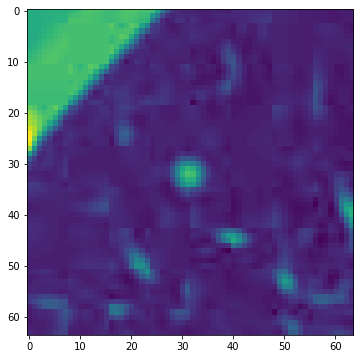

In [200]:
plot_detections_from_labels(imagefiles, predicted_paths[0])

#### Routine to predict nodules

Input: 
- patient id -> enter the patient id
- testdir -> the dir where the images for the patient are extracted an placed
- nodule_num -> the number of nodules as per ground truth in the patient

In [13]:
root_dir = '/app/yolov5'

In [59]:
import re
import subprocess
def predict_nodules(patient_id, testdir, nodule_num, root_dir):
    predicted_paths = []
    for nodule in range(nodule_num):
        source_dir = testdir + "/" + str(patient_id) + "/images/" + str(nodule)
        temp_dir = root_dir + '/temp'
        if not os.path.exists(temp_dir):
            os.makedirs(temp_dir)
        temp_file = temp_dir + "/" + 'temp.txt'
        print("Reading data from {}".format(source_dir))
        predict_command = "python detect.py --weights {} --img 512 --conf 0.25 --save-txt --source {} 2>&1 | tee {}".format(model_weights, source_dir, temp_file)
        print("Running command:\n")
        print(predict_command)
        ret_code = os.system(predict_command)
        print("Command executed with code {}".format(ret_code))
        print("Scanning output file {}".format(temp_file))
        with open(temp_file) as f:
            line = f.read()
            rc = re.compile(r'Results saved to (.*)')
            m = rc.search(line)
            if (m is not None) and (len(m.groups())>=1):
                ansi_escape = re.compile(r'\x1B(?:[@-Z\\-_]|\[[0-?]*[ -/]*[@-~])')
                result = ansi_escape.sub('', m[1])
                print("Predicted and saved the results to {}/{}".format('/app/yolov5', result))
            else:
                print("Could not save the predictions!")
            predicted_paths.append(root_dir + "/" + result)
    return predicted_paths

### Test pipeline for a patient

- For a patient id, extract the images and the ground truth bounding box coordinates and save them in one directory, one directory per nodule
- Run the prediction using the bext weights and save the results
- Plot the predictions and compare with the actual images and the ground truth bounding box

In [65]:
%cd /app/yolov5

/app/yolov5


In [102]:
print (root_dir)

/app/yolov5


In [66]:
testdir = root_dir + '/test/'
patient_id = 'LIDC-IDRI-0012'
nodule_num = save_patient_image_and_bbox(patient_id, testdir)
print("Found {} nodules in patient {}".format(nodule_num, patient_id))
predicted_paths = predict_nodules(patient_id, testdir, nodule_num, root_dir)
print("Found a total of {} nodules".format(len(predicted_paths)))

100%|██████████| 2/2 [00:00<00:00, 351.89it/s]

Directory /app/yolov5/test//LIDC-IDRI-0012 exists, removing!
Creating directory /app/yolov5/test//LIDC-IDRI-0012/images
Creating directory /app/yolov5/test//LIDC-IDRI-0012/labels
Reading data for patient LIDC-IDRI-0012



Lossy conversion from int16 to uint8. Range [-2048, 1374]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1590]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1540]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1307]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1203]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1260]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1205]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1103]. Convert image to uint8 prior to saving to suppress this warning.
Lossy c

Number of nodules for patient LIDC-IDRI-0012 is 12
Saved 1 images for nodule 0 of patient LIDC-IDRI-0012
Saved 2 images for nodule 0 of patient LIDC-IDRI-0012
Saved 3 images for nodule 0 of patient LIDC-IDRI-0012
Saved 1 images for nodule 1 of patient LIDC-IDRI-0012
Saved 2 images for nodule 1 of patient LIDC-IDRI-0012
Saved 3 images for nodule 1 of patient LIDC-IDRI-0012
Saved 1 images for nodule 2 of patient LIDC-IDRI-0012
Saved 2 images for nodule 2 of patient LIDC-IDRI-0012


Lossy conversion from int16 to uint8. Range [-2048, 1238]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1184]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1263]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1267]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1211]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1267]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1267]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1211]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Saved 3 images for nodule 2 of patient LIDC-IDRI-0012
Saved 1 images for nodule 3 of patient LIDC-IDRI-0012
Saved 2 images for nodule 3 of patient LIDC-IDRI-0012
Saved 3 images for nodule 3 of patient LIDC-IDRI-0012
Saved 4 images for nodule 3 of patient LIDC-IDRI-0012
Saved 5 images for nodule 3 of patient LIDC-IDRI-0012
Saved 2 images for nodule 4 of patient LIDC-IDRI-0012
Saved 4 images for nodule 4 of patient LIDC-IDRI-0012


Lossy conversion from int16 to uint8. Range [-2048, 1179]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1267]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1267]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1211]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1211]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1211]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1179]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1179]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Saved 5 images for nodule 4 of patient LIDC-IDRI-0012
Saved 2 images for nodule 5 of patient LIDC-IDRI-0012
Saved 5 images for nodule 5 of patient LIDC-IDRI-0012
Saved 7 images for nodule 5 of patient LIDC-IDRI-0012
Saved 8 images for nodule 5 of patient LIDC-IDRI-0012
Saved 1 images for nodule 6 of patient LIDC-IDRI-0012


Lossy conversion from int16 to uint8. Range [-2048, 1353]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2002]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2022]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1887]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2002]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2002]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2022]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2022]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Saved 2 images for nodule 6 of patient LIDC-IDRI-0012
Saved 3 images for nodule 6 of patient LIDC-IDRI-0012
Saved 1 images for nodule 7 of patient LIDC-IDRI-0012
Saved 2 images for nodule 7 of patient LIDC-IDRI-0012
Saved 3 images for nodule 7 of patient LIDC-IDRI-0012
Saved 2 images for nodule 8 of patient LIDC-IDRI-0012
Saved 4 images for nodule 8 of patient LIDC-IDRI-0012


Lossy conversion from int16 to uint8. Range [-2048, 1580]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1887]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1887]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1887]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1580]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1580]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1887]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Saved 6 images for nodule 8 of patient LIDC-IDRI-0012
Saved 7 images for nodule 8 of patient LIDC-IDRI-0012
Saved 3 images for nodule 9 of patient LIDC-IDRI-0012
Saved 5 images for nodule 9 of patient LIDC-IDRI-0012
Saved 6 images for nodule 9 of patient LIDC-IDRI-0012
Saved 3 images for nodule 10 of patient LIDC-IDRI-0012


Lossy conversion from int16 to uint8. Range [-2048, 1580]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1580]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1580]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1691]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1819]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1832]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1684]. Convert image to uint8 prior to saving to suppress this warning.


Saved 6 images for nodule 10 of patient LIDC-IDRI-0012
Saved 8 images for nodule 10 of patient LIDC-IDRI-0012
Saved 1 images for nodule 11 of patient LIDC-IDRI-0012
Saved 2 images for nodule 11 of patient LIDC-IDRI-0012
Saved 3 images for nodule 11 of patient LIDC-IDRI-0012
Found 12 nodules in patient LIDC-IDRI-0012
Reading data from /app/yolov5/test//LIDC-IDRI-0012/images/0
Running command:

python detect.py --weights /app/yolov5/runs/train/yolov5s_results30/weights/best.pt --img 512 --conf 0.25 --save-txt --source /app/yolov5/test//LIDC-IDRI-0012/images/0 2>&1 | tee /app/yolov5/temp/temp.txt
Command executed with code 0
Scanning output file /app/yolov5/temp/temp.txt
Predicted and saved the results to /app/yolov5/runs/detect/exp161
Reading data from /app/yolov5/test//LIDC-IDRI-0012/images/1
Running command:

python detect.py --weights /app/yolov5/runs/train/yolov5s_results30/weights/best.pt --img 512 --conf 0.25 --save-txt --source /app/yolov5/test//LIDC-IDRI-0012/images/1 2>&1 | tee 

In [67]:
!cat /app/yolov5/temp/temp.txt

/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:104.)
  return torch._C._cuda_getDeviceCount() > 0
YOLOv5 🚀 v6.0-39-g5d4258f torch 1.8.0a0+52ea372 CPU

Fusing layers... 
Model Summary: 213 layers, 7007428 parameters, 0 gradients, 15.8 GFLOPs
detect: weights=['/app/yolov5/runs/train/yolov5s_results30/weights/best.pt'], source=/app/yolov5/test//LIDC-IDRI-0012/images/11, imgsz=[512, 512], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
image 1/3 /app/

In [69]:
!cat runs/detect/exp172/labels/LIDC-IDRI-0012_11_84.txt

0 0.320312 0.729492 0.0117188 0.0136719


Number of images 4


IsADirectoryError: [Errno 21] Is a directory: '/app/yolov5/runs/detect/exp161/labels'

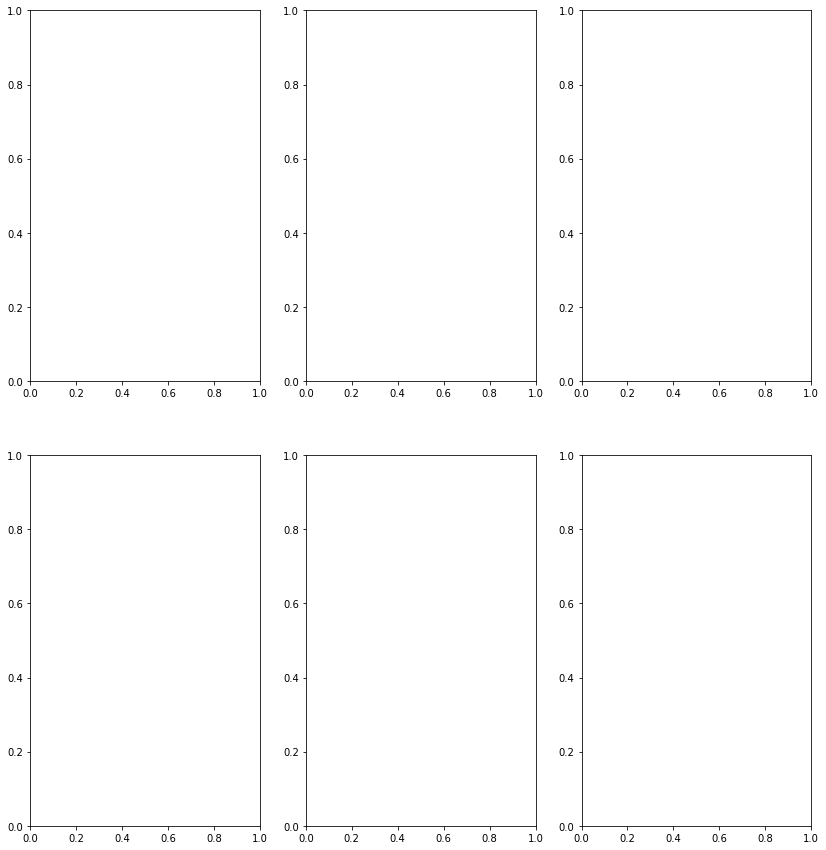

In [70]:
plot_detections(predicted_paths[0])

#### Plot and compare the predicted bounding box vs the actual bounding box

In [52]:
import matplotlib.patches as patches
def plot_and_compare(predicted_paths, patient_id, nodule_num, test_root_dir=testdir):
    
    #get the directories
    imagedirname = None
    labeldirname = None
    dirname = patient_id#.replace('-','_')
    patientdir = test_root_dir + "/" + dirname
    imagedirname = patientdir + "/" + 'images'
    labeldirname = patientdir + "/" + 'labels'
    
    
    images = os.listdir(predicted_paths[nodule_num])
    labeldir = labeldirname + "/" + str(nodule_num)
    print("Loading labels from {}".format(labeldir))
    labels = os.listdir(labeldir)
    
    imagedir = imagedirname + "/" + str(nodule_num)
    source_images = os.listdir(imagedir)
    
    num_images_row = 1
    print("Number of images {}".format(len(images)))
    if len(images) > num_images_row: # need rows more than one
        num_rows = math.ceil(len(images)/num_images_row)
        f, a = plt.subplots(num_rows, num_images_row*2, figsize=(14, 35))
    c = 0
    for idx, (imgstr, src_imgstr) in enumerate(zip(images, source_images)):
        img = Image.open(predicted_paths[nodule_num] + "/" + imgstr)
        src_img = Image.open(imagedir + "/" + src_imgstr)
        if c > num_images_row-1:
            c = 0
        a[int(idx/num_images_row)][c].imshow(np.array(img))
        a[int(idx/num_images_row)][c+1].imshow(np.array(src_img))
        src_labelstr = src_imgstr.replace('.jpg','.txt')
        
        with open(labeldir + "/" + src_labelstr) as f:
            line = f.read()
            _, x, y, w, h = line.split(' ')
            x, y, w, h = float(x), float(y), float(w), float(h)
            rect = patches.Rectangle((x, y), (w), (h), linewidth=1, edgecolor='r', facecolor='none')
            a[int(idx/num_images_row)][c+1].add_patch(rect)
            
        c += 1
    if c < num_images_row:
        for j in list(range(num_images_row,c,-1)):
            a.flat[-(num_images_row-j+1)].set_visible(False)
    plt.show()

Loading labels from /app/yolov5/test/LIDC-IDRI-0012/labels/3
Number of images 5


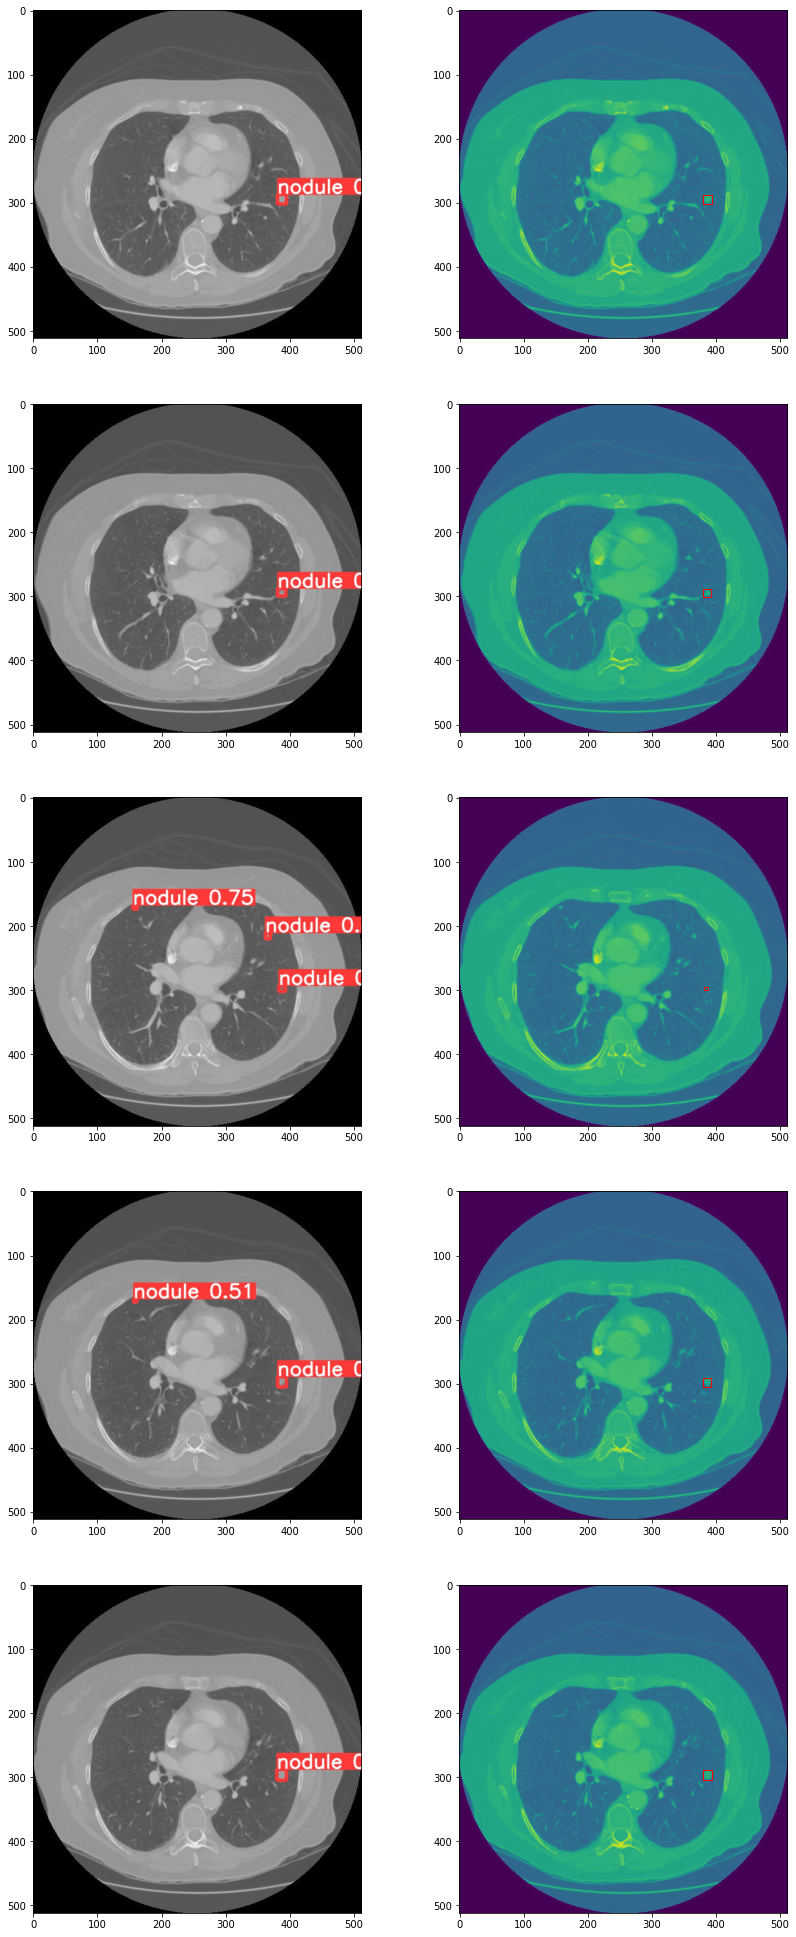

In [53]:
plot_and_compare(predicted_paths, 'LIDC-IDRI-0012', 3, '/app/yolov5/test')

In [58]:
ls /app/yolov5/runs/detect/exp149

LIDC-IDRI-0012_0_44.jpg  LIDC-IDRI-0012_0_45.jpg  LIDC-IDRI-0012_0_46.jpg


In [54]:
import matplotlib.patches as patches
def crop_and_compare(predicted_paths, patient_id, nodule_num, test_root_dir=testdir):
    
    #get the directories
    imagedirname = None
    labeldirname = None
    dirname = patient_id#.replace('-','_')
    patientdir = test_root_dir + "/" + dirname
    imagedirname = patientdir + "/" + 'images'
    labeldirname = patientdir + "/" + 'labels'
    
    
    images = os.listdir(predicted_paths[nodule_num])
    labeldir = labeldirname + "/" + str(nodule_num)
    print("Loading labels from {}".format(labeldir))
    labels = os.listdir(labeldir)
    
    imagedir = imagedirname + "/" + str(nodule_num)
    source_images = os.listdir(imagedir)
    
    num_images_row = 1
    print("Number of images {}".format(len(images)))
    if len(images) > num_images_row: # need rows more than one
        num_rows = math.ceil(len(images)/num_images_row)
        f, a = plt.subplots(num_rows, num_images_row*2, figsize=(14, 35))
    c = 0
    for idx, (imgstr, src_imgstr) in enumerate(zip(images, source_images)):
        img = Image.open(predicted_paths[nodule_num] + "/" + imgstr)
        src_img = Image.open(imagedir + "/" + src_imgstr)
        if c > num_images_row-1:
            c = 0
        a[int(idx/num_images_row)][c].imshow(np.array(img))
        a[int(idx/num_images_row)][c+1].imshow(np.array(src_img))
        src_labelstr = src_imgstr.replace('.jpg','.txt')
        
        with open(labeldir + "/" + src_labelstr) as f:
            line = f.read()
            _, x, y, w, h = line.split(' ')
            x, y, w, h = float(x), float(y), float(w), float(h)
            rect = patches.Rectangle((x, y), (w), (h), linewidth=1, edgecolor='r', facecolor='none')
            a[int(idx/num_images_row)][c+1].add_patch(rect)
            print(x, y, x+w, y+h)
        c += 1
    if c < num_images_row:
        for j in list(range(num_images_row,c,-1)):
            a.flat[-(num_images_row-j+1)].set_visible(False)
    plt.show()

Loading labels from /app/yolov5/test/LIDC-IDRI-0012/labels/3
Number of images 5
379.5 288.5 394.5 302.5
380.5 288.5 392.5 300.5
381.5 295.5 387.5 300.5
379.5 290.5 392.5 304.5
379.5 288.5 393.5 303.5


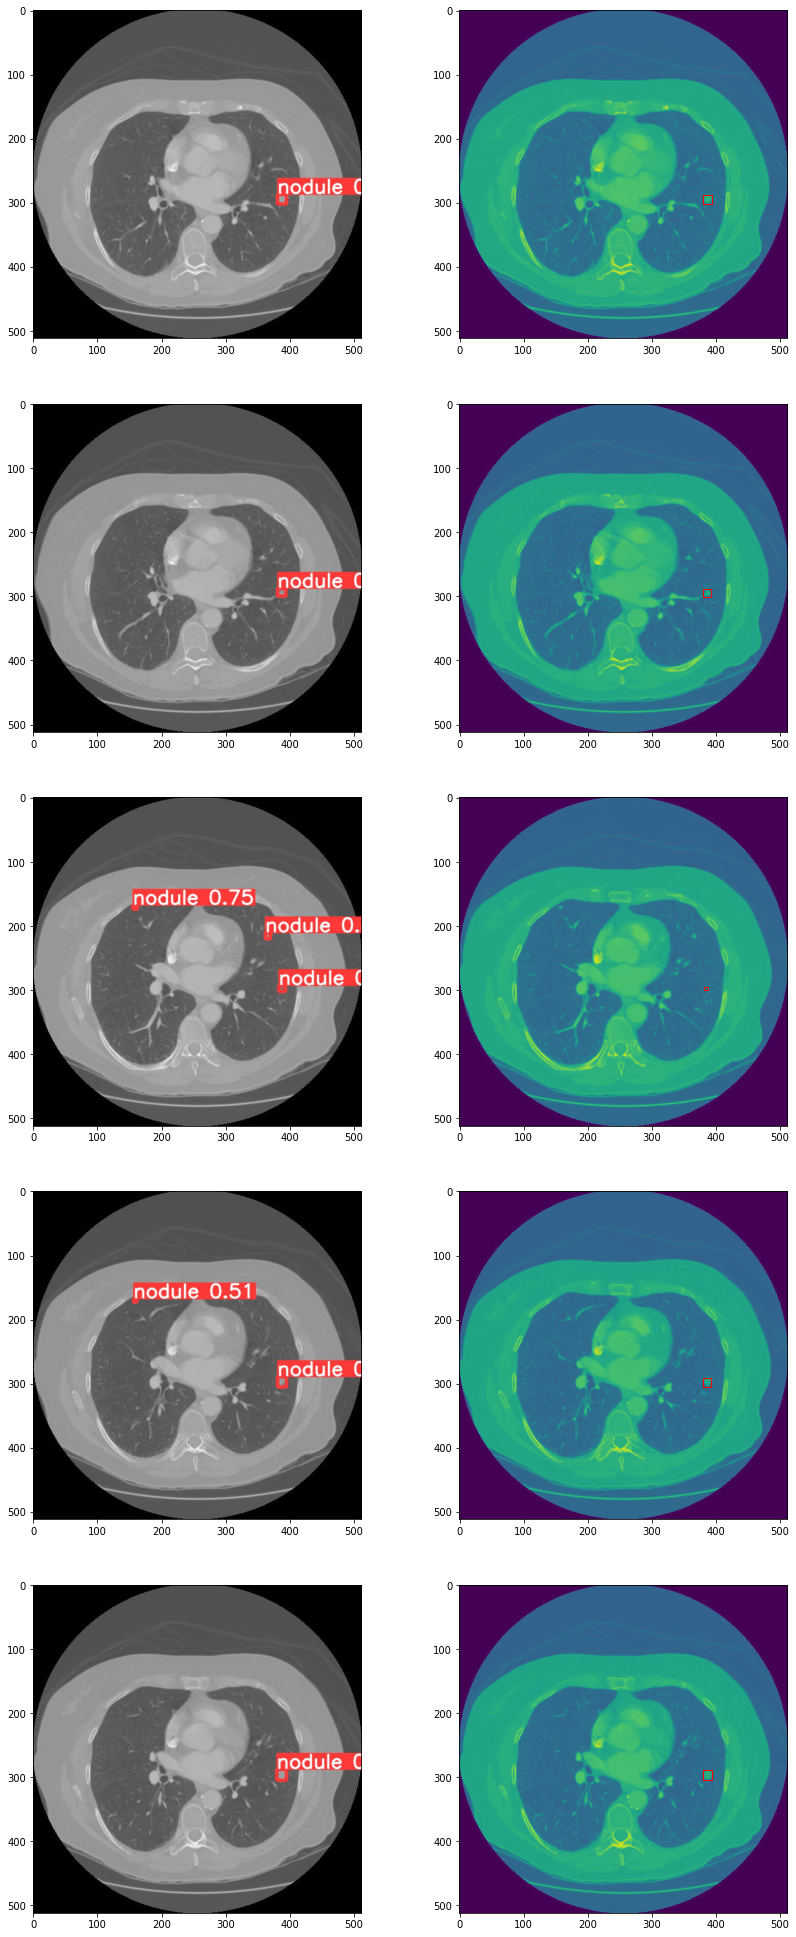

In [55]:
crop_and_compare(predicted_paths, 'LIDC-IDRI-0012', 3, '/app/yolov5/test')

#### Predict the segment

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision
import time
from torch import optim
from torch.nn.parallel import DistributedDataParallel as DDP

In [23]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1)
        self.relu1 = nn.ReLU()
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)
        self.relu2 = nn.ReLU()
        self.bn2   = nn.BatchNorm2d(out_ch)
    
    def forward(self, x):
        return self.bn2(self.relu2(self.conv2(self.bn1(self.relu1(self.conv1(x))))))
    

class Encoder(nn.Module):
    def __init__(self, chs=(1,32,64,128,256)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(256, 128, 64, 32)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            x        = torch.cat([x, encoder_features[i]], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    

class Unet(nn.Module):
    def __init__(self, enc_chs=(1,32,64,128,256), dec_chs=(256, 128, 64, 32), num_class=1, retain_dim=False, out_sz=(64,64)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [24]:
print(torch.__version__)
print("Number of GPUs =", torch.cuda.device_count())

1.8.0a0+52ea372
Number of GPUs = 0


In [35]:
model = Unet(enc_chs=(1,32,64,128,256,512), dec_chs=(512, 256, 128, 64, 32))
model = torch.nn.parallel.DataParallel(model, device_ids=[0, 1]).cuda()

In [36]:
device = torch.device("cuda")

In [37]:
summary(model, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
              ReLU-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
            Conv2d-4           [-1, 32, 64, 64]           9,248
              ReLU-5           [-1, 32, 64, 64]               0
       BatchNorm2d-6           [-1, 32, 64, 64]              64
             Block-7           [-1, 32, 64, 64]               0
         MaxPool2d-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
           Conv2d-12           [-1, 64, 32, 32]          36,928
             ReLU-13           [-1, 64, 32, 32]               0
      BatchNorm2d-14           [-1, 64,

In [48]:
# DICE only for the images which has nodules in ground truth
def dice_coeff(y_true, y_pred):
    smooth = 0.0001
    #print('label shape=', y_true.ndim)
    if y_true.ndim == 2:
        y_true = y_true[np.newaxis,:,:]
    true_nodules = torch.sum(y_true, dim=[1,2])
    idxs = torch.where(true_nodules>0)
    y_true = y_true[idxs]
    y_pred = y_pred[idxs]
    if idxs[0].shape[0] <=0:
        return torch.tensor(0.0)
    else:
    #return torch.mean( (2. * torch.sum(y_true * y_pred, dim=1) + smooth) / (torch.sum(y_true, dim=1) + torch.sum(y_pred, dim=1) + smooth) )
        return torch.mean((2. *torch.sum(y_true * y_pred, dim = [1,2]) + smooth)/(torch.sum(y_true, dim=[1,2]) + torch.sum(y_pred, dim=[1,2]) + smooth), dim=[0])

In [1]:
# IoU only for the images which has nodules in ground truth
def iou_coeff(y_true, y_pred):
    smooth = 0.0001
    if y_true.ndim == 2:
        y_true = y_true[np.newaxis,:,:]
    true_nodules = torch.sum(y_true, dim=[1,2])
    idxs = torch.where(true_nodules>0)
    y_true = y_true[idxs]
    y_pred = y_pred[idxs]
    if idxs[0].shape[0] <=0:
        return torch.tensor(0.0)
    else:
        return torch.mean((torch.sum(y_true * y_pred, dim = [1,2]) + smooth) / 
                          (torch.sum(y_true, dim=[1,2]) + torch.sum(y_pred, dim=[1,2]) 
                           - torch.sum(y_true * y_pred, dim = [1,2]) + smooth), dim=[0])

In [27]:
#test_image_files = os.listdir('/app/unet_test_from_fullsize_image/test/images/')
test_image_files = os.listdir('/app/data/unet/test/images/')
test_mask_files = [im_file.replace('img', 'mask') for im_file in test_image_files]
print("Test files: {}".format(len(test_image_files)))

Test files: 361


#### The dataloader

In [29]:
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

val_transform = transforms.Compose([
             transforms.ToTensor(),
             ])
mask_transform = transforms.Compose([transforms.ToTensor()])

In [30]:
import cv2
from PIL import Image
class NoduleDataset(Dataset):
    def __init__(self, root_dir, image_paths, mask_paths, transforms=None, image_shape=(128,128), augment=False):
        super().__init__()
        self.augment = augment
        self.image_shape = image_shape
        self.batch_size = len(image_paths)
        self.root_dir = root_dir
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image = cv2.imread(self.root_dir + 'images/' + self.image_paths[index])

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mask = cv2.imread(self.root_dir + 'masks/' + self.mask_paths[index])

        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        (thresh, mask) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        if self.transforms:
            image = self.transforms(image)
        mask = mask_transform(mask)
        #convert from Boolean to int (0,1)
        mask = mask.to(torch.uint8)
        mask = (mask > 0).float()
        return image, mask
            

batch_size = 16
num_workers = 0

#nodule_data_test = NoduleDataset('/app/unet_test_from_fullsize_image/test/',test_image_files, test_mask_files, transforms=val_transform, augment=False)
nodule_data_test = NoduleDataset('/app/data/unet/test/',test_image_files, test_mask_files, transforms=val_transform, augment=False)
test_loader = DataLoader(nodule_data_test, shuffle=True, batch_size = batch_size,
                             num_workers = num_workers)
print("Number of test files are {}".format(len(nodule_data_test)))

Number of test files are 361


In [40]:
from tqdm import tqdm
def calculate_dice_score_eval(model, loader):
    scores = []
    batch_iou_scores = []
    batch_dice_score = []
    least_dice = 1
    least_label = None
    least_pre = None
    with torch.no_grad():
        for i, data in tqdm(enumerate(loader)):
            inputs, labels = data[0].to(device), data[1].to(device)
            mask_pre_prob = torch.sigmoid(model(inputs))#.detach().cpu().numpy()
            outputs = np.squeeze(mask_pre_prob).detach().cpu()
            mask_pre = np.where(outputs>0.5, 1,0)
            mask_pre = torch.from_numpy(mask_pre)
            score = dice_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
            iou_score = iou_coeff(np.squeeze(labels).detach().cpu(), mask_pre)
            score_map = {'id': i, 'dice': score.item()}
            scores.append(score_map)
            if score < least_dice:
                least_dice = score
                least_label = labels
                least_pre = mask_pre
            batch_dice_score.append(score)
            batch_iou_scores.append(iou_score)
            if (i % 100) == 0:
                print("Accumulated dice coeff {}".format(torch.mean(torch.from_numpy(np.array(batch_dice_score)))))
    final_score = torch.mean(torch.from_numpy(np.array(batch_dice_score)))
    final_iou_score = torch.mean(torch.from_numpy(np.array(batch_iou_scores)))
    print("dice score: {}, IoU: {}".format(final_score, final_iou_score))
    return final_score, least_dice, least_label, least_pre, scores, final_iou_score

In [41]:
%cd /app

/app


In [42]:
# DICE only for the images which has nodules in ground truth
def dice_coeff(y_true, y_pred):
    smooth = 0.0001
    if y_true.ndim == 2:
        y_true = y_true[np.newaxis,:,:]
    if y_pred.ndim == 2:
        y_pred = y_pred[np.newaxis,:,:]
    true_nodules = torch.sum(y_true, dim=[1,2])
    idxs = torch.where(true_nodules>0)
    y_true = y_true[idxs]
    y_pred = y_pred[idxs]
    if idxs[0].shape[0] <=0:
        return torch.tensor(0.0)
    else:
        return torch.mean((2. *torch.sum(y_true * y_pred, dim = [1,2]) + smooth)/(torch.sum(y_true, dim=[1,2]) + torch.sum(y_pred, dim=[1,2]) + smooth), dim=[0])

In [43]:
# IoU only for the images which has nodules in ground truth
def iou_coeff(y_true, y_pred):
    smooth = 0.0001
    if y_true.ndim == 2:
        y_true = y_true[np.newaxis,:,:]
    true_nodules = torch.sum(y_true, dim=[1,2])
    idxs = torch.where(true_nodules>0)
    y_true = y_true[idxs]
    y_pred = y_pred[idxs]
    if idxs[0].shape[0] <=0:
        return torch.tensor(0.0)
    else:
        return torch.mean((torch.sum(y_true * y_pred, dim = [1,2]) + smooth) / 
                          (torch.sum(y_true, dim=[1,2]) + torch.sum(y_pred, dim=[1,2]) 
                           - torch.sum(y_true * y_pred, dim = [1,2]) + smooth), dim=[0])

In [47]:
if torch.cuda.device_count() > 0:
    device = torch.device("cuda")
else:
    device = 'cpu'
seg_model = Unet(enc_chs=(1,32,64,128,256,512), dec_chs=(512, 256, 128, 64, 32))
if torch.cuda.device_count() > 0:
    seg_model = torch.nn.parallel.DataParallel(seg_model, device_ids=[0,1]).cuda()
else:
    seg_model = torch.nn.parallel.DataParallel(seg_model)
seg_model.load_state_dict(torch.load('runs/unet_lidc_122/best_133.pth', map_location='cpu'))

seg_model.eval()
final_score, least_dice, least_label, least_pre, scores, final_iou_score = calculate_dice_score_eval(seg_model, test_loader)
print("Final test dice score = {}, IoU = {}".format(final_score, final_iou_score))

1it [00:00,  2.92it/s]

Accumulated dice coeff 0.7923008799552917


23it [00:07,  2.89it/s]

dice score: 0.8037751317024231, IoU: 0.7165714502334595
Final test dice score = 0.8037751317024231, IoU = 0.7165714502334595


In [45]:
def load_best_model():
    if torch.cuda.device_count() > 0:
        device = torch.device("cuda")
    else:
        device = 'cpu'
    seg_model = Unet(enc_chs=(1,32,64,128,256,512), dec_chs=(512, 256, 128, 64, 32))
    if torch.cuda.device_count() > 0:
        seg_model = torch.nn.parallel.DataParallel(seg_model, device_ids=[0,1]).cuda()
    else:
        seg_model = torch.nn.parallel.DataParallel(seg_model)
    seg_model.load_state_dict(torch.load('runs/unet_lidc_122/best_133.pth', map_location='cpu'))
    seg_model.eval()
    return seg_model

In [46]:
# verify some images and predictions
image_file = 'LIDC-IDRI-0012_52.jpg'
test_dir = '/data/unet/test/'
image_path = test_dir + 'images/' + image_file
mask_path = test_dir + 'masks/' + image_file.replace('img','mask')
seg_model = load_best_model()
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = val_transform(image)

mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#add new axis to input data for batch dimension
image = image[None, :]
mask_pre_prob = torch.sigmoid(seg_model(image))#.detach().cpu().numpy()
outputs = np.squeeze(mask_pre_prob).detach().cpu()
mask_pre = np.where(outputs>0.5, 1,0)
mask_pre = torch.from_numpy(mask_pre)

#draw plots
image = np.squeeze(image)
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(image, 'bone')
ax1.set_axis_off()
ax1.set_title("Source image")

mask = np.squeeze(mask)
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(mask, 'bone')
ax2.set_axis_off()
ax2.set_title("Original mask")

mask_pre = np.squeeze(mask_pre)
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(mask_pre, 'bone')
ax3.set_axis_off()
ax3.set_title("Predicted mask")

error: OpenCV(4.4.0) /tmp/pip-req-build-99ib2vsi/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
